In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib import gridspec
import mplhep
import uncertainties as unc

plt.style.use('belle2')
#%jsroot on

#%run functins.ipynb

2024-07-22 11:21:39.786410: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 11:21:39.839653: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 11:21:39.840470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 11:21:41.025661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0mumupip4Streams.root"
file_signal="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0mumupip200000.root"


In [3]:
class trimVars():
    @staticmethod
    def trimCosTheta_L(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('abs(cosTheta_L) < 0.75')
            if q2 == 4:
                df = df.query('abs(cosTheta_L) < 0.95')
        
        if int(Btree) == 521:
            if pi == 'pip':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 == 4:
                    df = df.query('abs(cosTheta_L) < 0.95')
            if pi =='pi0':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 != 4:
                    df = df.query('abs(cosTheta_L) < 0.9')
        return df
    
    @staticmethod
    def trimCosTheta_K(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('cosTheta_K > -0.9')
            elif q2 != 4:
                df = df.query('cosTheta_K > -0.9')
            else:
                df = df.query('abs(cosTheta_K) < 0.95')
                
        if int(Btree) == 521:
            if q2 == 1:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                else:
                    df = df.query('cosTheta_K > 0.9')
            elif q2 != 4:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                elif pi == 'pi0':
                    df = df.query('cosTheta_K > -0.9')
                    
            elif q2 == 4:
                if pi == 'pip':
                    df = df.query('abs(cosTheta_K) > -0.95')
                if pi == 'pi0':
                    df = df.query('abs(cosTheta_K) < 0.9')
        return df
    
    @staticmethod
    def trimmers(df, Btree, pi, ll, q2):
        df = trimVars.trimCosTheta_L(df, Btree, pi, ll, q2)
        df = trimVars.trimCosTheta_K(df, Btree, pi, ll, q2)
        return df

def process_MC_data_combined(file_path_signal, file_path_background, particle_type, Btree, pi, ll, q2):
    def process_mc_data(file_path, q2):
        df = uproot.open(f"{file_path}:rec511")
        df = df.arrays(library='pd')
        mc_data = trimVars.trimmers(df, Btree, pi, ll, q2)
        mc_cut = mc_data.query('NNPass==1')
        mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        return mc_cut_best_candidate

    mc_cut_best_candidate_signal = process_mc_data(file_path_signal, q2)
    mc_cut_best_candidate_background = process_mc_data(file_path_background, q2)

    if q2 == 11 or q2 == 12:
        mc_q2cut_background = mc_cut_best_candidate_background.query(f"q2reg == {q2}")

        if particle_type == 'ele':
            cut = f"lm_genMotherPDG == {443 if q2 == 11 else 100443} and lp_genMotherPDG == {443 if q2 == 11 else 100443} and abs(Kst_genMotherPDG) == 511 and Kst_isSignal == 1 and abs(lm_PDG) == 11 and abs(lp_PDG) == 11 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        elif particle_type == 'mu':
            cut = f"lm_genMotherPDG == {443 if q2 == 11 else 100443} and lp_genMotherPDG == {443 if q2 == 11 else 100443} and abs(Kst_genMotherPDG) == 511 and Kst_isSignal == 1 and abs(lm_PDG) == 13 and abs(lp_PDG) == 13 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        else:
            raise ValueError(f"Unknown particle_type: {particle_type}")

        deltaE_range = (-0.15, 0.15)

        mc_signal_q2cut_jpsi_kst_wot_filter = mc_q2cut_background.query(cut)
        mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')

        mc_bkg_q2cut_jpsi_kst_wot_filter = mc_q2cut_background.query(f'not ({cut})')
        mc_bkg_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst_wot_filter.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        mc_Continuum_bkg_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst.query('isContinuumEvent==1')
        mc_Bmeson_bkg_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst.query('isContinuumEvent!=1')

        mc_signal_weight_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_bkg_weight_q2cut_jpsi_kst = mc_bkg_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_Continuum_bkg_weight_q2cut_jpsi_kst = mc_Continuum_bkg_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
        mc_Bmeson_bkg_weight_q2cut_jpsi_kst = mc_Bmeson_bkg_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]

        # Data
        mc_signal_data = mc_signal_q2cut_jpsi_kst
        mc_bkg_data = mc_bkg_q2cut_jpsi_kst
        mc_Continuum_bkg_data = mc_Continuum_bkg_q2cut_jpsi_kst
        mc_Bmeson_bkg_data = mc_Bmeson_bkg_q2cut_jpsi_kst
        # Weight Data
        mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
        mc_bkg_weight = mc_bkg_weight_q2cut_jpsi_kst
        mc_Continuum_bkg_weight = mc_Continuum_bkg_weight_q2cut_jpsi_kst
        mc_Bmeson_bkg_weight = mc_Bmeson_bkg_weight_q2cut_jpsi_kst

        return mc_signal_data, mc_bkg_data, mc_Continuum_bkg_data, mc_Bmeson_bkg_data, mc_signal_weight, mc_bkg_weight, mc_Continuum_bkg_weight, mc_Bmeson_bkg_weight

    else:
        if q2 in [1, 2, 3, 4]:
            excluded_q2reg_values = [11, 12]
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f"q2reg == {q2}")
            mc_q2cut_background = mc_cut_best_candidate_background.query(f"q2reg == {q2}")
        elif q2 == 0:
            included_q2reg_values = [1, 2, 3, 4]
            excluded_q2reg_values = [11, 12]
            mc_q2cut_signal = mc_cut_best_candidate_signal.query(f'q2reg in {included_q2reg_values} and q2reg not in {excluded_q2reg_values}')
            mc_q2cut_background = mc_cut_best_candidate_background.query(f'q2reg in {included_q2reg_values} and q2reg not in {excluded_q2reg_values}')
        else:
            raise ValueError("Invalid q2 value")

        deltaE_range = (-0.15, 0.15)

        mc_particle_type_signal = mc_q2cut_signal.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        mc_particle_type_only_signal = mc_particle_type_signal.query('isSignal==1')
        mc_particle_type_scf = mc_particle_type_signal.query('isSignal==0')

        mc_particle_type_bkg = mc_q2cut_background.query('deltaE >= @deltaE_range[0] and deltaE <= @deltaE_range[1]')
        mc_particle_type_Continuum_bkg = mc_particle_type_bkg.query('isContinuumEvent==1')
        mc_particle_type_Bmeson_bkg = mc_particle_type_bkg.query('isContinuumEvent!=1')

        mc_particle_type_signal_weight = mc_particle_type_signal["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_only_signal_weight = mc_particle_type_only_signal["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_scf_weight = mc_particle_type_scf["PIDCorrectionAndAcceptanceWeight"]

        mc_particle_type_bkg_weight = mc_particle_type_bkg["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_Continuum_bkg_weight = mc_particle_type_Continuum_bkg["PIDCorrectionAndAcceptanceWeight"]
        mc_particle_type_Bmeson_bkg_weight = mc_particle_type_Bmeson_bkg["PIDCorrectionAndAcceptanceWeight"]

        return (mc_particle_type_signal, mc_particle_type_only_signal, mc_particle_type_scf,
                mc_particle_type_bkg, mc_particle_type_Continuum_bkg, mc_particle_type_Bmeson_bkg,
                mc_particle_type_signal_weight, mc_particle_type_only_signal_weight, mc_particle_type_scf_weight,
                mc_particle_type_bkg_weight, mc_particle_type_Continuum_bkg_weight, mc_particle_type_Bmeson_bkg_weight)


In [4]:
mc_mu_signal,mc_mu_only_signal,mc_mu_scf,mc_mu_bkg, mc_mu_Continuum_bkg, mc_mu_Bmeson_bkg,mc_mu_signal_weight,mc_mu_only_signal_weight,mc_mu_scf_weight,mc_mu_bkg_weight, mc_mu_Continuum_bkg_weight, mc_mu_Bmeson_bkg_weight =process_MC_data_combined(file_signal, file_bkg,'mu', 511, 'pip', 'mumu', 1)


/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/uproot/interpretation/library.py:806: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


## Yield

In [5]:
def fit_fixed(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type,q2reg):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.288))
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
    else:
        raise ValueError(f"Unknown label: {label}")
        
    if particle_type == 'ele':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
    elif particle_type == 'mu':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight

    r = round(np.random.rand(), 4)
    parameter_df = pd.read_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}_{q2reg}.csv")
    
    
    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=True)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zfit.pdf.CrystalBall(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
            alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
    elif model_type == 'cb_gauss':

        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"].values[0], floating=False)

        label_dataset_name_cb_fixed = zfit.pdf.CrystalBall(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
            alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.1)  

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb_fixed, label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)



    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.8)
        
        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed,label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)

    
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"].values[0], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.8)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus_fixed,label_dataset_name_gauss_fixed],
            fracs=frac_particle_type_label_dataset_name_model_type,
            obs=obs_label)
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.28819 )
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
    
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])


  
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.1)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed, label_dataset_name_argus_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label
        )
            
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        
    data_label_dataset_name = zfit.data.Data.from_pandas(mc_label_particle_type_dataset_name_data, obs=obs_label, weights=mc_label_particle_type_dataset_name_weight)
    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type_fixed, data=data_label_dataset_name)
    minimizer_label_dataset_name = zfit.minimize.Minuit()
    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)
        
    return label_dataset_name_model_type_fixed, result_label_dataset_name
    

# signal
Mbc_only_signal_cb_fixed,result_Mbc_only_signal = fit_fixed('Mbc','mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed,result_deltaE_only_signal = fit_fixed('deltaE','mu', 'signal',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed,result_Mbc_scf= fit_fixed('Mbc','mu', 'scf', mc_mu_scf["Mbc"], mc_mu_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed,result_deltaE_scf= fit_fixed('deltaE','mu', 'scf', mc_mu_scf["deltaE"], mc_mu_scf_weight,'poly_gauss',0)


#Bmeson_bkg
Mbc_Bmeson_bkg_argus_gauss_fixed,result_Mbc_Bmeson_bkg= fit_fixed('Mbc','mu', 'Bmeson_bkg',  mc_mu_Bmeson_bkg["Mbc"], mc_mu_Bmeson_bkg_weight,'argus_gauss',0)
deltaE_Bmeson_bkg_poly_gauss_fixed,result_deltaE_Bmeson_bkg= fit_fixed('deltaE','mu', 'Bmeson_bkg',  mc_mu_Bmeson_bkg["deltaE"], mc_mu_Bmeson_bkg_weight,'poly_gauss',0)


#Continuum_bkg
Mbc_Continuum_bkg_argus_fixed,result_Mbc_Continuum_bkg= fit_fixed('Mbc','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["Mbc"], mc_mu_Continuum_bkg_weight,'poly_argus',0)
deltaE_Continuum_bkg_poly_gauss_fixed,result_Mbc_only_signal= fit_fixed('deltaE','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["deltaE"], mc_mu_Continuum_bkg_weight,'poly_gauss',0)


print(result_Mbc_only_signal.params)
print(result_Mbc_only_signal.valid)
print(result_deltaE_only_signal.params)
print(result_deltaE_only_signal.valid)
print(result_Mbc_scf.params)
print(result_Mbc_scf.valid)
print(result_deltaE_scf.params)
print(result_deltaE_scf.valid)
print(result_Mbc_Bmeson_bkg.params)
print(result_Mbc_Bmeson_bkg.valid)
print(result_deltaE_Bmeson_bkg.params)
print(result_deltaE_Bmeson_bkg.valid)
print(result_Mbc_Continuum_bkg.params)
print(result_Mbc_Continuum_bkg.valid)
print(result_Mbc_only_signal.params)
print(result_Mbc_only_signal.valid)
''' 

    return label_dataset_name_model_type_fixed
    
# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','mu', 'signal',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed('Mbc','mu', 'scf', mc_mu_scf["Mbc"], mc_mu_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed('deltaE','mu', 'scf', mc_mu_scf["deltaE"], mc_mu_scf_weight,'poly_gauss',0)


#Bmeson_bkg
Mbc_Bmeson_bkg_argus_gauss_fixed= fit_fixed('Mbc','mu', 'Bmeson_bkg',  mc_mu_Bmeson_bkg["Mbc"], mc_mu_Bmeson_bkg_weight,'argus_gauss',0)
deltaE_Bmeson_bkg_poly_gauss_fixed= fit_fixed('deltaE','mu', 'Bmeson_bkg',  mc_mu_Bmeson_bkg["deltaE"], mc_mu_Bmeson_bkg_weight,'poly_gauss',0)


#Continuum_bkg
Mbc_Continuum_bkg_argus_fixed= fit_fixed('Mbc','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["Mbc"], mc_mu_Continuum_bkg_weight,'poly_argus',0)
deltaE_Continuum_bkg_poly_gauss_fixed= fit_fixed('deltaE','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["deltaE"], mc_mu_Continuum_bkg_weight,'poly_gauss',0)      
        
'''

        

name                                             value  (rounded)    at limit
---------------------------------------------  ------------------  ----------
frac_mu_deltaE_Continuum_bkg_poly_gauss_0.706              1.0019       False
True
name                                     value  (rounded)    at limit
-------------------------------------  ------------------  ----------
frac_mu_deltaE_signal_cb_gauss_0.4963               0.134       False
True
name                                  value  (rounded)    at limit
----------------------------------  ------------------  ----------
frac_mu_Mbc_scf_argus_gauss_0.2499            0.484882       False
True
name                                    value  (rounded)    at limit
------------------------------------  ------------------  ----------
frac_mu_deltaE_scf_poly_gauss_0.3371            0.933724       False
True
name                                         value  (rounded)    at limit
-----------------------------------------  -----------

' \n\n    return label_dataset_name_model_type_fixed\n    \n# signal\nMbc_only_signal_cb_fixed = fit_fixed(\'Mbc\',\'mu\', \'signal\', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,\'cb\',0)\ndeltaE_only_signal_cb_gauss_fixed= fit_fixed(\'deltaE\',\'mu\', \'signal\',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,\'cb_gauss\',0)\n\n\n#scf\nMbc_scf_argus_gauss_fixed= fit_fixed(\'Mbc\',\'mu\', \'scf\', mc_mu_scf["Mbc"], mc_mu_scf_weight,\'argus_gauss\',0)\ndeltaE_scf_poly_gauss_fixed= fit_fixed(\'deltaE\',\'mu\', \'scf\', mc_mu_scf["deltaE"], mc_mu_scf_weight,\'poly_gauss\',0)\n\n\n#Bmeson_bkg\nMbc_Bmeson_bkg_argus_gauss_fixed= fit_fixed(\'Mbc\',\'mu\', \'Bmeson_bkg\',  mc_mu_Bmeson_bkg["Mbc"], mc_mu_Bmeson_bkg_weight,\'argus_gauss\',0)\ndeltaE_Bmeson_bkg_poly_gauss_fixed= fit_fixed(\'deltaE\',\'mu\', \'Bmeson_bkg\',  mc_mu_Bmeson_bkg["deltaE"], mc_mu_Bmeson_bkg_weight,\'poly_gauss\',0)\n\n\n#Continuum_bkg\nMbc_Continuum_bkg_argus_fixed= fit_fixed(\'Mbc\',\'mu\', \'Continuum_b

In [6]:
import numpy as np
import pandas as pd
import zfit

def fit_extended_model(Mbc_only_signal_pdf, Mbc_scf_pdf, deltaE_only_signal_pdf, deltaE_scf_pdf, 
                       Mbc_Bmeson_bkg_pdf, Mbc_Continuum_bkg_pdf, deltaE_Bmeson_bkg_pdf, deltaE_Continuum_bkg_pdf, 
                       data, weights):
    
    obs_Mbc = zfit.Space('Mbc', limits=(5.20, 5.288))
    obs_deltaE = zfit.Space('deltaE', limits=(-0.15, 0.15))
    
    combined_obs = obs_Mbc * obs_deltaE
    
    # Random number for parameter names
    r = np.round(np.random.rand(), decimals=4)
    
    # Signal model
    Mbc_signal_pdf = Mbc_only_signal_pdf
    deltaE_signal_pdf = deltaE_only_signal_pdf
    
    signal_product_pdf = zfit.pdf.ProductPDF([Mbc_signal_pdf, deltaE_signal_pdf])
    signal_yield = zfit.Parameter(f"signal_yield_{r}", 10000)
    signal_extended = signal_product_pdf.create_extended(signal_yield)

    # Background model
    frac_Mbc_bkg1 = zfit.Parameter(f'frac_Mbc_bkg1_{r}', 0.006)
    frac_deltaE_bkg1 = zfit.Parameter(f'frac_deltaE_bkg1_{r}', 0.004)
    frac_Mbc_bkg2 = zfit.Parameter(f'frac_Mbc_bkg2_{r}', 0.284)
    frac_deltaE_bkg2 = zfit.Parameter(f'frac_deltaE_bkg2_{r}', 0.34)
    
    Mbc_background_pdf = zfit.pdf.SumPDF([Mbc_scf_pdf, Mbc_Bmeson_bkg_pdf, Mbc_Continuum_bkg_pdf], 
                                         fracs=[frac_Mbc_bkg1, frac_Mbc_bkg2])
    deltaE_background_pdf = zfit.pdf.SumPDF([deltaE_scf_pdf, deltaE_Bmeson_bkg_pdf, deltaE_Continuum_bkg_pdf], 
                                            fracs=[frac_deltaE_bkg1, frac_deltaE_bkg2])

    background_product_pdf = zfit.pdf.ProductPDF([Mbc_background_pdf, deltaE_background_pdf])
    background_yield = zfit.Parameter(f"background_yield_{r}", 10000)
    background_extended = background_product_pdf.create_extended(background_yield)

    # Total model sum
    total_model = zfit.pdf.SumPDF([signal_extended, background_extended])
    
    # Create a joint data for Mbc and deltaE
    combined_data = zfit.data.Data.from_pandas(data, obs=combined_obs, weights=weights)

    # Create an extended NLL for the model and data
    nll = zfit.loss.ExtendedUnbinnedNLL(model=total_model, data=combined_data)

    # Minimize the NLL
    minimizer = zfit.minimize.Minuit()  # Set the tolerance to a smaller value
    result = minimizer.minimize(nll)
    
    return Mbc_signal_pdf, deltaE_signal_pdf, Mbc_background_pdf, deltaE_background_pdf, signal_extended, background_extended, total_model, result


# Assuming mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_Continuum_bkg, mc_mu_only_signal_weight, 
# mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, and mc_mu_Continuum_bkg_weight are defined

Signal_Mbc = mc_mu_only_signal["Mbc"]
Signal_deltaE = mc_mu_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_mu_scf["Mbc"], mc_mu_Bmeson_bkg["Mbc"], mc_mu_Continuum_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_mu_scf["deltaE"], mc_mu_Bmeson_bkg["deltaE"], mc_mu_Continuum_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)

Signal_weight = mc_mu_only_signal_weight
Background_weight = pd.concat([mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, mc_mu_Continuum_bkg_weight])

Mbc_signal_pdf, deltaE_signal_pdf, Mbc_background_pdf, deltaE_background_pdf, signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_only_signal_cb_fixed, Mbc_scf_argus_gauss_fixed, deltaE_only_signal_cb_gauss_fixed, deltaE_scf_poly_gauss_fixed,
    Mbc_Bmeson_bkg_argus_gauss_fixed, Mbc_Continuum_bkg_argus_fixed, deltaE_Bmeson_bkg_poly_gauss_fixed, deltaE_Continuum_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight])
)

# Uncomment the following lines if needed:
#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                                             value  (rounded)               errors    at limit
---------------------------------------------  ------------------  -------------------  ----------
signal_yield_0.3577                                       21019.2  -1.5e+02   +1.5e+02       False
background_yield_0.3577                                   7516.65  -     97   +     98       False
mu_mu_Mbc_signal_cb_0.2512                                5.27967  -1.9e-05   +1.8e-05       False
frac_mu_deltaE_signal_cb_gauss_0.4963                    0.117369  - 0.0043   + 0.0044       False
frac_Mbc_bkg1_0.3577                                  0.000217508  - 0.0035   +  0.035       False
frac_Mbc_bkg2_0.3577                                     0.154603  -  0.099   +  0.093       False
frac_mu_Mbc_scf_argus_gauss_0.2499                        7.42527  -   0.52   +   0.52       False
frac_mu_Mbc_Bmeson_bkg_argus_gauss_0.6687                 0.95118  -   0.17   +  0.059       False
frac_mu_Mb

In [7]:
signal_yield_value = result.params[signal_extended.get_yield()]['value']
background_yield_value = result.params[background_extended.get_yield()]['value']

# Round the values
signal_event_fit = round(signal_yield_value, 3)
bkg_event_fit = round(background_yield_value, 3)


mc_mu_signal_weight = pd.concat([mc_mu_only_signal_weight])
mc_mu_bkg_weight = pd.concat([mc_mu_scf_weight,mc_mu_Bmeson_bkg_weight,mc_mu_Continuum_bkg_weight])

mc_mu_signal_MC = round(sum(mc_mu_signal_weight), 3)
mc_mu_bkg_MC = round(sum(mc_mu_bkg_weight), 3)


# Print the results
print("Results from Fit:")
print("Signal Events =", signal_event_fit)
print("Background Events =", bkg_event_fit)
print()

print("Results from MC Data:")
print("Signal Events in MC Data =", mc_mu_signal_MC)
print("Background Events in MC Data =", mc_mu_bkg_MC)
print()

errors_sig_events = mc_mu_signal_MC - signal_event_fit
print("Signal Events different =", round(errors_sig_events, 3))

errors_bkg_events = mc_mu_bkg_MC - bkg_event_fit
print("Background Events different=", round(errors_bkg_events, 3))


Results from Fit:
Signal Events = 21019.178
Background Events = 7516.645

Results from MC Data:
Signal Events in MC Data = 21140.875
Background Events in MC Data = 7414.687

Signal Events different = 121.697
Background Events different= -101.958


## with fit data ##

In [8]:
import numpy as np
from uncertainties import ufloat

# Extract signal yield and its error from fit result
signal_yield = result.params[signal_extended.get_yield()]['value']
signal_yield_errors = result.params[signal_extended.get_yield()]['errors']

# Calculate the standard deviation from the given error range
signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2


# Create an ufloat for the signal yield with its uncertainty
signal_yield_with_uncertainty = ufloat(signal_yield, signal_yield_error)

# Adjust the signal yield for the percentage change (18.53%)
adjusted_signal_yield_with_uncertainty = signal_yield_with_uncertainty * (1 + 0.1853)

# Constants
cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns

# Calculate the number of B mesons
N_bb_mesons = cross_section_nb * (4 * luminosity_nb)

# Branching ratio calculation
Y_B0B0 = ufloat(48.6, 0.6) / 100
BR_MC = adjusted_signal_yield_with_uncertainty / ((2 * N_bb_mesons) * Y_B0B0)

# PDG value for comparison
central_value = 1.03e-6
average_uncertainty = (0.19e-6 + 0.17e-6) / 2
BR_PDG = ufloat(central_value, average_uncertainty)

# Print results
print("B _to_ee_and_K*_for_muctron_Branching_ratio:", BR_MC)
print("B _to_ee_and_K*_Branching_ratio_from_PDG:", BR_PDG)


B _to_ee_and_K*_for_muctron_Branching_ratio: (3.25+/-0.05)e-05
B _to_ee_and_K*_Branching_ratio_from_PDG: (1.03+/-0.18)e-06


## BR with MC weights ##

In [9]:
mc_mu_signal_MC = sum(mc_mu_signal_weight)

# Adjust the signal yield for the percentage change (18.53%)
adjusted_signal_yield_with_uncertainty = mc_mu_signal_MC * (1 + 0.1853)

# Constants
cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns

# Calculate the number of B mesons
N_bb_mesons = cross_section_nb * (4 * luminosity_nb)

# Branching ratio calculation
Y_B0B0 = ufloat(48.6, 0.6) / 100
BR_MC = adjusted_signal_yield_with_uncertainty / ((2 * N_bb_mesons) * Y_B0B0)

# PDG value for comparison
central_value = 1.03e-6
average_uncertainty = (0.19e-6 + 0.17e-6) / 2
BR_PDG = ufloat(central_value, average_uncertainty)

# Print results
print("B _to_ee_and_K*_for_muctron_Branching_ratio:", BR_MC)
print("B _to_ee_and_K*_Branching_ratio_from_PDG:", BR_PDG)


B _to_ee_and_K*_for_muctron_Branching_ratio: (3.27+/-0.04)e-05
B _to_ee_and_K*_Branching_ratio_from_PDG: (1.03+/-0.18)e-06


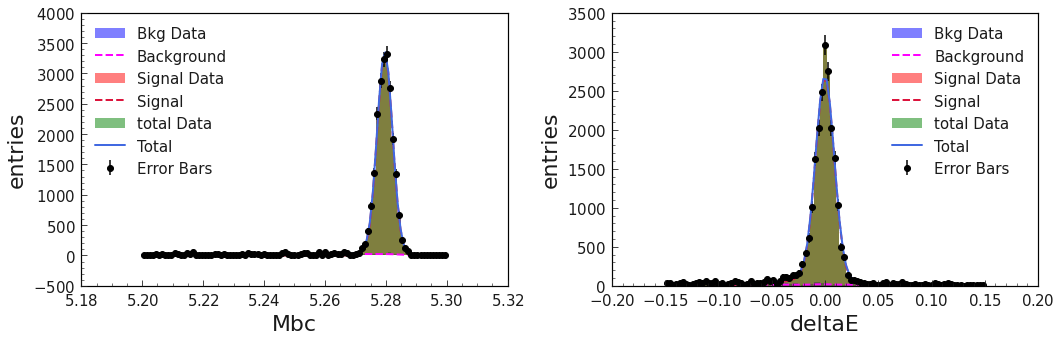

In [10]:
def plot_variable(ax, variable, data_only_signal, data_scf, data_background, weight_only_signal, weight_scf, weight_background, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable],data_scf[variable]])
    bkg_df = data_background[variable]
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = pd.concat([weight_only_signal, weight_scf])
    bkg_weight =weight_background
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.30, 100)
        x_fit = np.linspace(5.20, 5.30, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.5, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(weight_background) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="Magenta", linewidth=2)

    # Plot the signal component
    ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red', alpha=0.5, label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(weight_only_signal) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green', alpha=0.5, label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('entries')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_only_signal_weight, mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_only_signal_weight, mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('q2regs_1 for muctron.png')
plt.show()


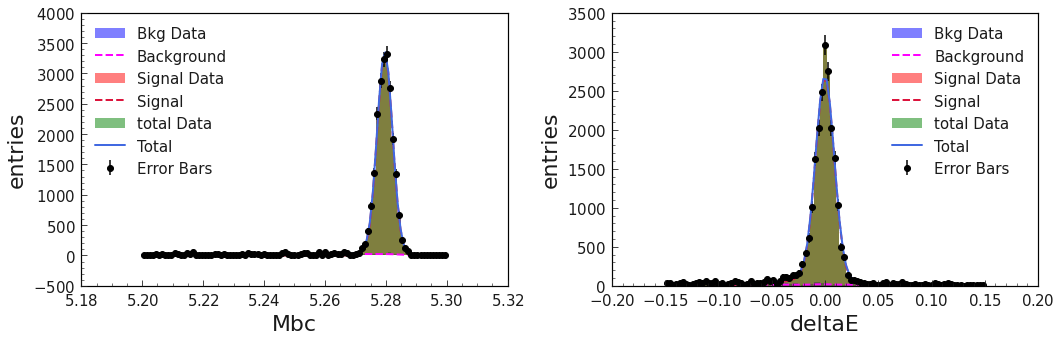

In [11]:
def plot_variable(ax, variable, data_only_signal, data_scf, data_background, weight_only_signal, weight_scf, weight_background, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable],data_scf[variable]])
    bkg_df = data_background[variable]
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = pd.concat([weight_only_signal, weight_scf])
    bkg_weight =weight_background
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.30, 100)
        x_fit = np.linspace(5.20, 5.30, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.5, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(weight_background) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="Magenta", linewidth=2)

    # Plot the signal component
    ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red', alpha=0.5, label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(weight_only_signal) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green', alpha=0.5, label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('entries')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_only_signal_weight, mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_only_signal_weight, mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('q2regs_1 for muctron.png')
plt.show()


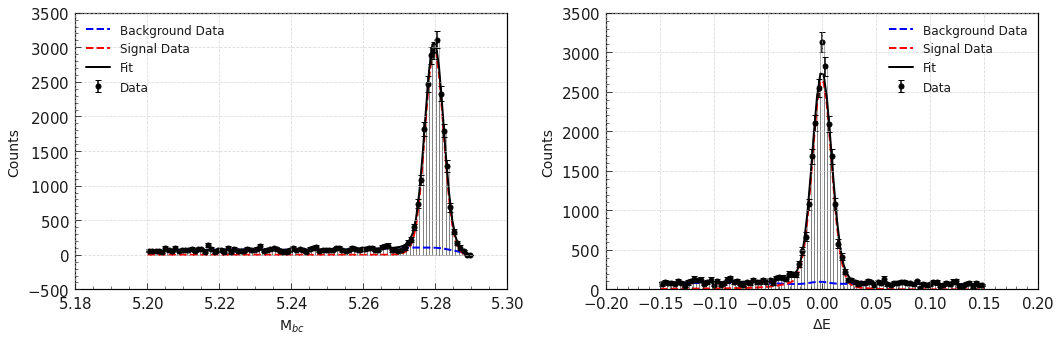

In [12]:
def plot_variable(ax, variable, data_only_signal, data_scf, Bmeson_bkg, Continuum_bkg, 
                  weight_only_signal, weight_scf, weight_Bmeson_bkg, weight_Continuum_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background,xaxis):    

    signal_df = pd.concat([data_only_signal[variable]])
    bkg_df = pd.concat([data_scf[variable], Bmeson_bkg[variable], Continuum_bkg[variable]])
    
    df_total = pd.concat([signal_df, bkg_df])
    
    signal_weight = weight_only_signal
    bkg_weight = pd.concat([weight_scf, weight_Bmeson_bkg, weight_Continuum_bkg])
    
    total_weight = pd.concat([signal_weight, bkg_weight])
    
    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.2901, 100)
        x_fit = np.linspace(5.20, 5.2901, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label=label_background, linestyle="--", color="blue", linewidth=2)

    # Plot the signal component
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label=label_signal, linestyle="--", color="red", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='white', alpha=0.3, edgecolor='black')
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bin_edges) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', markersize=5, color='black', label='Data', capsize=3)

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Fit", color="black", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(xaxis, fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_Continuum_bkg, 
              mc_mu_only_signal_weight, mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, mc_mu_Continuum_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Background Data","M$_{bc}$")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_Continuum_bkg, 
              mc_mu_only_signal_weight, mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, mc_mu_Continuum_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Background Data",'$\\Delta$E')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

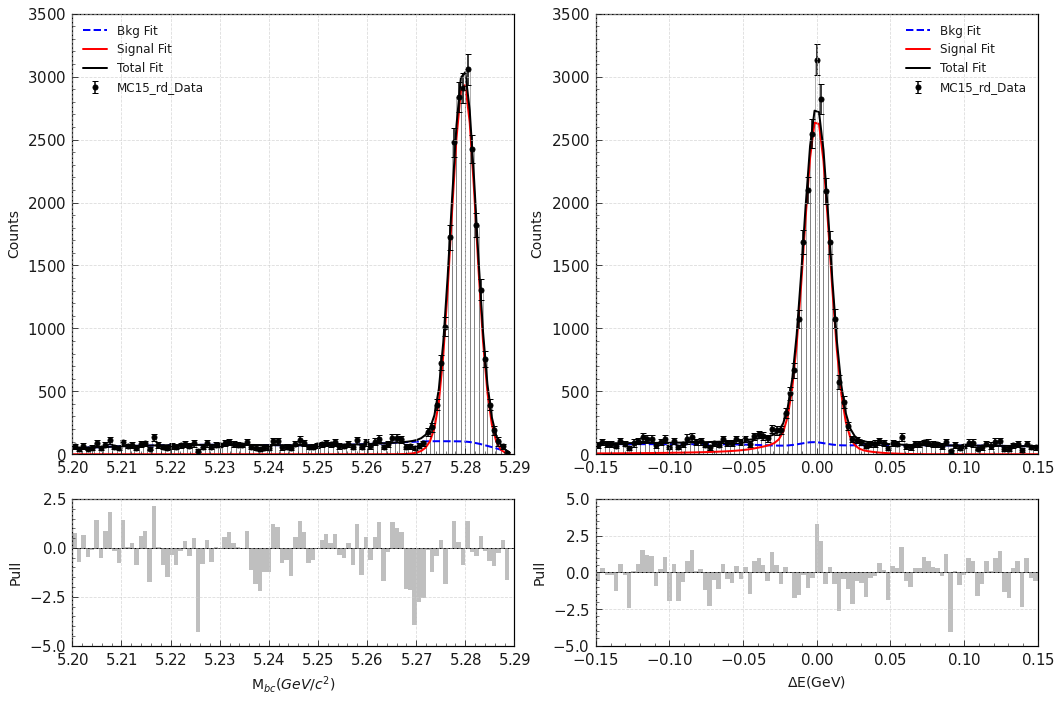

In [14]:
def plot_variable(ax, ax_pull, variable, data_only_signal, data_scf, Bmeson_bkg, Continuum_bkg, 
                  weight_only_signal, weight_scf, weight_Bmeson_bkg, weight_Continuum_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background, xaxis):    

    signal_df = pd.concat([data_only_signal[variable]])
    bkg_df = pd.concat([data_scf[variable], Bmeson_bkg[variable], Continuum_bkg[variable]])
    
    df_total = pd.concat([signal_df, bkg_df])
    
    signal_weight = weight_only_signal
    bkg_weight = pd.concat([weight_scf, weight_Bmeson_bkg, weight_Continuum_bkg])
    
    total_weight = pd.concat([signal_weight, bkg_weight])
    
    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.289, 100)
        x_fit = np.linspace(5.20, 5.289, 100)
        ax.set_xlim(5.20, 5.29)
        ax_pull.set_xlim(5.20, 5.29)
        
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)
        ax.set_xlim(-0.15, 0.15)
        ax_pull.set_xlim(-0.15, 0.15)


    # Plot the background component
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label=label_background, linestyle="--", color="blue", linewidth=2)

    # Plot the signal component
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label=label_signal, linestyle="-", color="red", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='white', alpha=0.3, edgecolor='black')
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bin_edges) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', markersize=5, color='black', label='MC15_rd_Data', capsize=3)

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit
    
    # Adjust y_total_fit to match the number of bins
    y_total_fit_binned = np.interp(bin_centers, x_fit, y_total_fit)
    ax.plot(x_fit, y_total_fit, label="Total Fit", color="black", linewidth=2)

    # Calculate pull and plot
    pulls = (n - y_total_fit_binned) / errors
    ax_pull.bar(bin_centers, pulls, width=np.diff(bin_edges), align='center', alpha=0.5, color='gray')
    ax_pull.axhline(0, color='black', linewidth=1)
    ax_pull.set_xlabel(xaxis, fontsize=14)
    ax_pull.set_ylabel('Pull', fontsize=14)
    ax_pull.grid(True, linestyle='--', alpha=0.7)
    
    # Add labels and legend
    #ax.set_xlabel(xaxis, fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_Continuum_bkg, 
              mc_mu_only_signal_weight, mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, mc_mu_Continuum_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_mu_only_signal, mc_mu_scf, mc_mu_Bmeson_bkg, mc_mu_Continuum_bkg, 
              mc_mu_only_signal_weight, mc_mu_scf_weight, mc_mu_Bmeson_bkg_weight, mc_mu_Continuum_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit", '$\\Delta$E(GeV)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('q2reg_1_muon_ri.pdf')
plt.show()